In [2]:
# Import necessary libraries
import jax.numpy as jnp
from jax import random, grad, jit, lax, jacrev
from jax.scipy.linalg import inv, svd, eigh, det
from jax.numpy.linalg import norm
from tqdm.auto import tqdm
from sklearn.datasets import make_spd_matrix
from jax_models import visualize_observations, Lorenz96, KuramotoSivashinsky, generate_true_states, generate_localization_matrix
from jax_filters import ensrf_steps, kalman_filter_process, ensrf_step
import jax
import matplotlib.pyplot as plt
from jax.tree_util import Partial
from functools import partial
from jax_vi import KL_gaussian, log_likelihood, KL_sum
jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_debug_nans", True)

N = 10 # number of Monte Carlo samples
n_ensemble = 5
observation_interval = 5


num_steps = 500  # Number of simulation steps

F = 8.0
dt = 0.05
J0 = 0
n = 40   # Number of state variables
key = random.PRNGKey(0)  # Random key for reproducibility
x0 = random.normal(key, (n,))
initial_state  = x0
# Noise covariances
Q = 0.03 * jnp.eye(n)  # Process noise covariance
R = 0.5 * jnp.eye(n)  # Observation noise covariance
H = jnp.eye(n) # Observation matrix (identity matrix for direct observation of all state variables)

n_ensemble = 5
observation_interval = 1
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state
m0 = initial_state
C0 = Q


# n = 256 # Dimensionality of the state space for KS model
# dt = 0.25  # Time step for the KS model
# ks_model = KuramotoSivashinsky(dt=dt, s=n, l=22, M=16)
# ks_step = Partial(ks_model.step)
# state_transition_function = ks_step
# jacobian_function = jacrev(ks_step, argnums=0)
# jac_func = Partial(jacobian_function)


F = 8.0
dt = 0.05
l96_model = Lorenz96(dt = dt, F = 8)
l96_step = Partial(l96_model.step)
# Generate true states and observations using the Lorenz '96 model

state_transition_function = l96_step

jacobian_function = jacrev(l96_step, argnums=0)
jac_func = Partial(jacobian_function)


observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l96_step, observation_interval)

In [3]:
@partial(jit, static_argnums=(0))
def generate_distance_matrix(n, distances):
    """
    Generate a localization matrix with learned distances.
    
    distances: A 1D array of size n/2 representing the learned distances.
    """
    half_n = n // 2
    full_distances = jnp.concatenate([distances, distances[::-1]])  
    i = jnp.arange(n)[:, None]
    j = jnp.arange(n)
    min_modulo_distance = jnp.minimum(jnp.abs(i - j), n - jnp.abs(i - j))
    r = full_distances[min_modulo_distance.astype(int)] 
    localization_matrix = r
    #localization_matrix = jnp.exp(-(r**2))
    return localization_matrix


In [4]:
key = random.PRNGKey(1)
half_n = n//2
# Initialize the distances
distances = jnp.sin(jnp.linspace(0, jnp.pi / 2, half_n))
loc_matrix = generate_distance_matrix(n, distances)

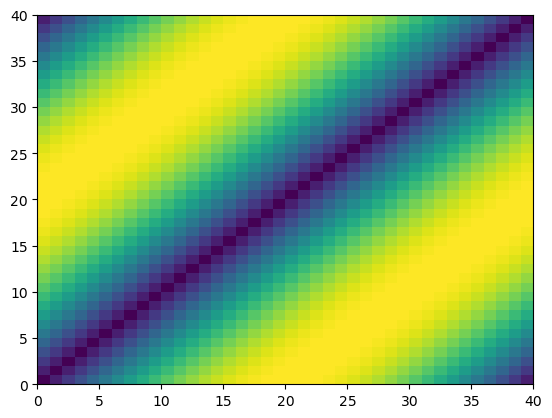

In [5]:
plt.pcolormesh(generate_localization_matrix(40, 2.4))
plt.pcolormesh(loc_matrix)

In [11]:
@jit
def var_cost(distances, inflation, model, ensemble_init, observations, H, Q, R, key, J, J0):
    localization_matrix = generate_distance_matrix(n, distances)
    pred_states, pred_covar, states, covariances = ensrf_steps(state_transition_function, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    pred_mean = jnp.mean(pred_states, axis = -1)
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(pred_mean, pred_covar, ensemble_mean, covariances, n, state_transition_function, Q, key)

    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, ensemble_mean, covariances), observations, H, R, num_steps, J0)  
    cost = kl_sum - jnp.nanmean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    
    return cost

In [12]:
inflation = 1.3  # Fixed starting value for inflation
alpha = 1e-4  # Learning rate
key = random.PRNGKey(0)  # Random key
N = 10  # Number of MC samples
m0 = initial_state
C0 = Q  # Initial covariance, assuming Q is your process noise covariance
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
localization_matrix = generate_distance_matrix(n, distances)

pred_states, pred_covar, states, covariances = ensrf_steps(state_transition_function, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)


In [13]:
observations.shape

(500, 40)

In [14]:
for inflation in jnp.arange(1,1.2,0.01):
    print(inflation)
    distances_opt = jnp.cos(jnp.linspace(0, jnp.pi, n//2))  # Cosine decay from 1 to 0
    key, subkey = random.split(key)
    print(jax.value_and_grad(var_cost)(distances_opt, inflation, state_transition_function, ensemble_init, observations, H, Q, R, subkey, num_steps, J0))

1.0
(Array(nan, dtype=float64), Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan], dtype=float64))
1.01
(Array(nan, dtype=float64), Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan], dtype=float64))
1.02
(Array(nan, dtype=float64), Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan], dtype=float64))
1.03
(Array(nan, dtype=float64), Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan], dtype=float64))
1.04
(Array(nan, dtype=float64), Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan], dtype=float64))
1.05
(Array(nan, dtype=float64), Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan], dtype=float64))
1.06
(Array(nan, 

In [15]:
distances_opt = jnp.sin(jnp.linspace(0, jnp.pi / 2, half_n))  # Cosine decay from 1 to 0

key, subkey = random.split(key)
var_cost(distances_opt, inflation, state_transition_function, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)

Array(nan, dtype=float64)

In [18]:
print(jax.value_and_grad(var_cost) (distances_opt, inflation, state_transition_function, ensemble_init, observations, H, Q, R, subkey, num_steps, J0))

(Array(38591.03909978, dtype=float64), Array([-6050465.97576785, -8671675.66422685,   186094.30225614,
       -4952512.02658795,  2525431.80126305,  1933102.29005466,
        3945474.94283186,  4827225.05027827,  1385938.65325605,
        2658488.87230224,  1738284.60463496,  1097329.1989547 ,
        3461823.8603314 ,   692120.32955014,   994547.91912149,
         917524.22881312,  1700674.0553249 , -1357289.72661612,
         220701.27003649, -9909141.76226594], dtype=float64))


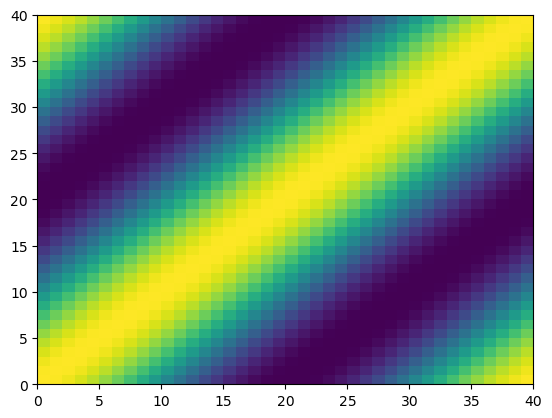

In [19]:
base_m, base_C, base_K = kalman_filter_process(state_transition_function, jac_func, m0, C0, observations, H, Q, R)
distances_opt = jnp.cos(jnp.linspace(0, jnp.pi, half_n))  # Cosine decay from 1 to 0
localization_matrix = generate_distance_matrix(n, distances_opt)
plt.pcolormesh(localization_matrix)

In [22]:
import properscoring
from IPython.display import clear_output
from jax import grad
from tqdm.notebook import tqdm
import jax.numpy as jnp
from jax import random
import pickle

# Initialize the distance array for gradient descent (n/2 values)
half_n = n // 2
key = random.PRNGKey(0)
distances_opt = jnp.cos(jnp.linspace(0, jnp.pi / 2, half_n))
localization_matrix = generate_distance_matrix(n, distances_opt)


# Other parameters
inflation = 1.1  # Fixed starting value for inflation
alpha = 1e-11  # Learning rate
key = random.PRNGKey(0)  # Random key
N = 10  # Number of MC samples
m0 = initial_state
C0 = Q  # Initial covariance, assuming Q is your process noise covariance
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T

crpss = []
rmses = []
true_div = []
costs = []
covars = []
distances_list = []

var_cost_grad = grad(var_cost, argnums=0)

for i in tqdm(range(100)):
    key, subkey = random.split(key)
    
    current_cost = var_cost(distances_opt, inflation, state_transition_function, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)
    costs.append(current_cost)
    grad_distances = var_cost_grad(distances_opt, inflation, state_transition_function, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)
    distances_opt -= alpha * grad_distances
    distances_list.append(distances_opt)
    localization_matrix = generate_distance_matrix(n, distances_opt)

    # Run the ensemble filter steps with the updated localization matrix
    pred_states, pred_covar, states, covariances = ensrf_steps(state_transition_function, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    rmse = jnp.sqrt(jnp.mean((ensemble_mean - true_states)**2))
    rmses.append(rmse)
    crps = properscoring.crps_ensemble(true_states, states).mean(axis=1).mean()
    crpss.append(crps)
    total_kl_divergence = 0
    for t in range(num_steps):  
        kl_div_t = KL_gaussian(n, ensemble_mean[t], covariances[t],  base_m[t], base_C[t])
        total_kl_divergence += kl_div_t
    true_div.append(total_kl_divergence / num_steps)
    covars.append(covariances)
    
    # Print the current state
    print(f"Iteration {i+1}, Distance Gradient Norm: {jnp.linalg.norm(grad_distances)}, RMSE: {rmse}, Current Cost: {current_cost}")

# Save the results using pickle
results = {
    'distances': distances_list,
    'crpss': crpss,
    'rmses': rmses,
    'true_div': true_div,
    'costs': costs,
}

with open('results_with_distances.pkl', 'wb') as f:
    pickle.dump(results, f)


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 1, Distance Gradient Norm: 16517781.213747252, RMSE: 0.9026173256028776, Current Cost: 38619.425768828354
Iteration 2, Distance Gradient Norm: 92387177.71697506, RMSE: 0.9871650877332847, Current Cost: 39597.02729673016
Iteration 3, Distance Gradient Norm: 1203718400.7390997, RMSE: 1.0888549415580033, Current Cost: 43150.08518537326
Iteration 4, Distance Gradient Norm: 86603589.79386075, RMSE: 1.0658024592843542, Current Cost: 47383.95734504207
Iteration 5, Distance Gradient Norm: 728783867.4481694, RMSE: 1.0003581110091233, Current Cost: 46507.442759622645
Iteration 6, Distance Gradient Norm: 61304669.69386514, RMSE: 0.930543619768194, Current Cost: 43713.73911745625
Iteration 7, Distance Gradient Norm: 102241953.24872248, RMSE: 1.193985772309605, Current Cost: 40796.85502260135
Iteration 8, Distance Gradient Norm: 379391201.8406077, RMSE: 0.9365793606537148, Current Cost: 52802.006346659444
Iteration 9, Distance Gradient Norm: 527242503.6333521, RMSE: 0.8900556048960103, Cu

In [24]:
import properscoring
from IPython.display import clear_output
from jax import grad
from tqdm.notebook import tqdm
import jax.numpy as jnp
from jax import random
import pickle
from datetime import datetime


# Initialize the distance array for gradient descent (n/2 values)
half_n = n // 2
key = random.PRNGKey(0)
distances_opt = jnp.cos(jnp.linspace(0, jnp.pi / 2, half_n))
localization_matrix = generate_distance_matrix(n, distances_opt)


# Other parameters
inflation = 1.1  # Fixed starting value for inflation
alpha = 5e-12  # Learning rate
key = random.PRNGKey(0)  # Random key
N = 10  # Number of MC samples
m0 = initial_state
C0 = Q  # Initial covariance, assuming Q is your process noise covariance
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T

crpss = []
rmses = []
true_div = []
costs = []
covars = []
distances_list = []

var_cost_grad = grad(var_cost, argnums=0)

for i in tqdm(range(100)):
    key, subkey = random.split(key)
    
    current_cost = var_cost(distances_opt, inflation, state_transition_function, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)
    costs.append(current_cost)
    grad_distances = var_cost_grad(distances_opt, inflation, state_transition_function, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)
    distances_opt -= alpha * grad_distances
    distances_list.append(distances_opt)
    localization_matrix = generate_distance_matrix(n, distances_opt)

    # Run the ensemble filter steps with the updated localization matrix
    pred_states, pred_covar, states, covariances = ensrf_steps(state_transition_function, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    rmse = jnp.sqrt(jnp.mean((ensemble_mean - true_states)**2))
    rmses.append(rmse)
    crps = properscoring.crps_ensemble(true_states, states).mean(axis=1).mean()
    crpss.append(crps)
    total_kl_divergence = 0
    for t in range(num_steps):  
        kl_div_t = KL_gaussian(n, ensemble_mean[t], covariances[t],  base_m[t], base_C[t])
        total_kl_divergence += kl_div_t
    true_div.append(total_kl_divergence / num_steps)
    covars.append(covariances)
    
    # Print the current state
    print(f"Iteration {i+1}, Distance Gradient Norm: {jnp.linalg.norm(grad_distances)}, RMSE: {rmse}, Current Cost: {current_cost}")

# Save the results using pickle
results = {
    'distances': distances_list,
    'crpss': crpss,
    'rmses': rmses,
    'true_div': true_div,
    'costs': costs,
}
current_time = datetime.now().strftime("%H-%M")
with open(f'results_with_distances_{current_time}.pkl', 'wb') as f:
    pickle.dump(results, f)


  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 1, Distance Gradient Norm: 16517781.213747252, RMSE: 0.9026978550108802, Current Cost: 38619.425768828354
Iteration 2, Distance Gradient Norm: 96104986.0795967, RMSE: 0.9028708489139706, Current Cost: 39625.64153164475
Iteration 3, Distance Gradient Norm: 16904551.136838444, RMSE: 1.0407289087688858, Current Cost: 39591.97277101528
Iteration 4, Distance Gradient Norm: 694476637.5115324, RMSE: 1.0766070091960576, Current Cost: 45537.13142484541
Iteration 5, Distance Gradient Norm: 27253148.938635934, RMSE: 0.9877066870920488, Current Cost: 47143.24416560595
Iteration 6, Distance Gradient Norm: 11701514.705150485, RMSE: 1.120519842572993, Current Cost: 43183.29025134686
Iteration 7, Distance Gradient Norm: 177928485.00539318, RMSE: 1.089653660463764, Current Cost: 49308.348860937076
Iteration 8, Distance Gradient Norm: 12134741.411528919, RMSE: 1.1121509028346346, Current Cost: 47809.501497815014
Iteration 9, Distance Gradient Norm: 80091502.54325229, RMSE: 1.1930864763376146, 

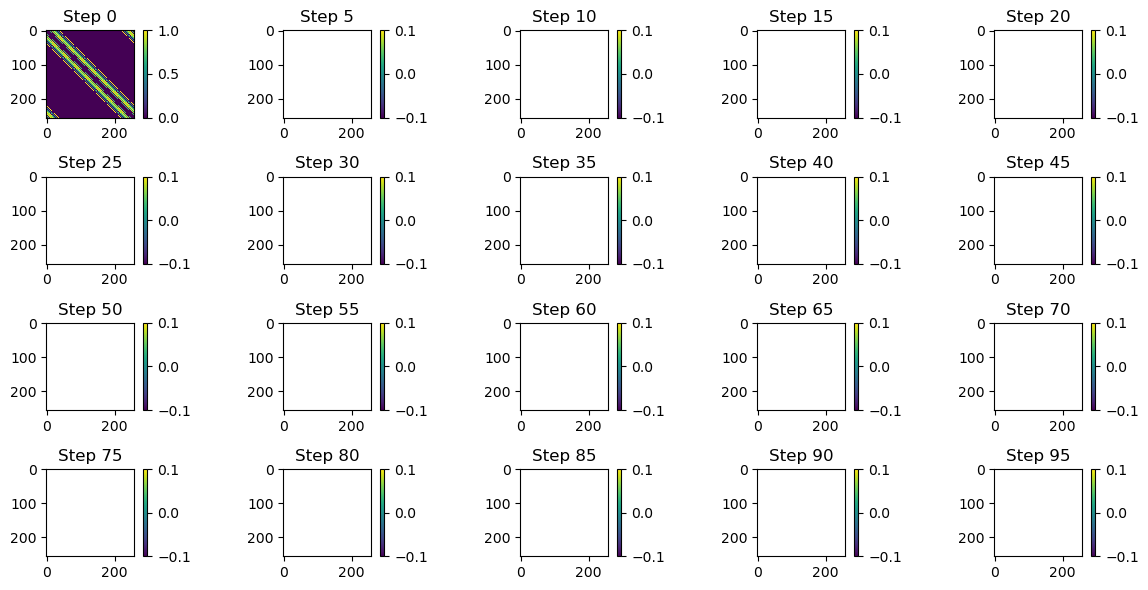

Final RMSE: nan
Final true divergence: nan


In [13]:
import pickle
import matplotlib.pyplot as plt
import jax.numpy as jnp

# Load the data from the pickle file
filename = 'results_with_distances.pkl' 
with open(filename, 'rb') as f:
    data = pickle.load(f)


distances = data.get('distances')
rmses = data.get('rmses')
true_div = data.get('true_div')
crpss = data.get('crpss')

localization_matrices = []

# Create and show an evolution of localization matrices based on distances
for i, d in enumerate(distances):
    localization_matrix = generate_distance_matrix(n, d)
    localization_matrices.append(localization_matrix)

# Plot the first few localization matrices over iterations
plt.figure(figsize=(12, 6))


for idx, step in enumerate(range(0, 100, 5)):  # Every 5th step
    plt.subplot(4, 5, idx + 1)
    plt.imshow(localization_matrices[step], cmap='viridis', interpolation='nearest')
    plt.title(f'Step {step}')
    plt.colorbar()


plt.tight_layout()
plt.show()

# Print some results
#print("Final distances:", distances[-1])
print("Final RMSE:", rmses[-1])
print("Final true divergence:", true_div[-1])


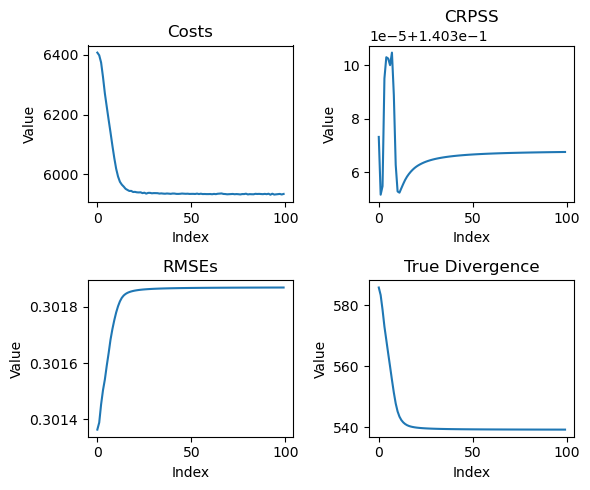

In [14]:
# unpack the results
distances_list = data['distances']
crpss = data['crpss']
rmses = data['rmses']
true_div = data['true_div']
costs = data['costs']

# create subplots to plot all metrics
fig, axs = plt.subplots(2, 2, figsize=(6, 5))

#plot costs
axs[0, 0].plot(costs)
axs[0, 0].set_title('Costs')
axs[0, 0].set_xlabel('Index')
axs[0, 0].set_ylabel('Value')

# plot CRPSS
axs[0, 1].plot(crpss)
axs[0, 1].set_title('CRPSS')
axs[0, 1].set_xlabel('Index')
axs[0, 1].set_ylabel('Value')

# plot RMSEs
axs[1, 0].plot(rmses)
axs[1, 0].set_title('RMSEs')
axs[1, 0].set_xlabel('Index')
axs[1, 0].set_ylabel('Value')

# plot True Divergence
axs[1, 1].plot(true_div)
axs[1, 1].set_title('True Divergence')
axs[1, 1].set_xlabel('Index')
axs[1, 1].set_ylabel('Value')

plt.tight_layout()
plt.show()







In [ ]:
plt.plot([3, 6, 12, 25, 50, 100, 200], [2.3, 5.75, 7.8, 11.6, 16, 26.8, 44.2])
plt.xlabel("Ensemble size")
plt.ylabel("Optimal localization radius")
plt.savefig("localization_radii.pdf")

In [17]:
data

{'distances': [Array([0.        , 0.02862416, 0.0801182 , 0.08475227, 0.15697662,
         0.1376297 , 0.22765812, 0.18550125, 0.28980363, 0.22718238,
         0.34174146, 0.26219421, 0.38283277, 0.29078376, 0.41331496,
         0.31391567, 0.43410234, 0.33305504, 0.44706298, 0.3500931 ,
         0.45429312, 0.36706054, 0.45820518, 0.38597589, 0.46138398,
         0.4085067 , 0.46580677, 0.43589956, 0.47335292, 0.46882336,
         0.48524167, 0.50742555, 0.50209516, 0.55116116, 0.52406928,
         0.5990292 , 0.55067786, 0.6496174 , 0.58112744, 0.70133617,
         0.61439026, 0.75239029, 0.64918032, 0.80100728, 0.68430778,
         0.84599407, 0.71864083, 0.88582463, 0.75138195, 0.9200209 ,
         0.7818293 , 0.94783725, 0.80967433, 0.96956634, 0.83471776,
         0.9853225 , 0.85722611, 0.99563059, 0.87748826, 1.00149459,
         0.8959109 , 1.00382221, 0.91303682, 1.00350855, 0.92921453,
         1.00159016, 0.94506086, 0.99890949, 0.96081192, 0.99631748,
         0.97670864, 